In [1]:
import pandas as pd
import numpy as np
df1 = pd.read_csv('train.csv')
other = pd.read_csv('unique_m.csv').drop(['critical_temp','material'],axis=1)
df = pd.concat([df1,other],axis=1)
original_columns = len(df.columns)
print(df.shape)
df.head()

(21263, 168)


,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,Ir,Pt,Au,Hg,Tl,Pb,Bi,Po,At,Rn
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0


In [30]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, Ridge,LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn import neighbors
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

In [3]:
cols = df.columns
# Create a new DataFrame with just the markdown
df2 = pd.DataFrame([['---',]*len(cols)], columns=cols)
#Create a new concatenated DataFrame
df3 = pd.concat([df2, df.head()])
#Save as markdown
df3.to_csv("raw_data.md", sep="|", index=False)

In [4]:
# remove all columns that have a very small variance
threshold=0.05
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=threshold).fit(df)
df = pd.DataFrame(selector.transform(df),columns=df.columns[selector.get_support()])
df.shape


(21263, 132)

In [5]:
#drop any duplicate features
df = df.transpose().drop_duplicates(keep='first').transpose()
print(df.shape)

(21263, 132)


In [6]:
#Now drop any correlated features
correlation_matrix = df.corr() 
mutually_correlated_features = set()  
for i in range(len(correlation_matrix.columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            if colname!='critical_temp':
                mutually_correlated_features.add(colname)
print(len(mutually_correlated_features))
df.drop(mutually_correlated_features,axis=1,inplace=True)
df.shape

55


(21263, 77)

In [7]:
#This gets rid of features that have a absolute correlation with the target less than 0.1

correlation_threshhold = 0.1

corr = pd.DataFrame(df.corr()['critical_temp'])
corr['abs'] = np.abs(corr['critical_temp'])
corr = corr.sort_values(by='abs',ascending=False).drop('abs',axis=1).dropna().reset_index()
corr = corr.rename(columns={'index':'feature','critical_temp':'corr'}).loc[1:]

low_correlated_features = list(corr[np.abs(corr['corr'])<=correlation_threshhold]['feature'])
df.drop(low_correlated_features,axis=1,inplace=True)
df.shape

(21263, 36)

In [8]:
print(str(original_columns-df.shape[1])+' features were found to be irrelevant')

132 features were found to be irrelevant


In [9]:
df.to_csv('data_filtered.csv')

In [10]:
df.shape

(21263, 36)

In [11]:
cols = df.columns
# Create a new DataFrame with just the markdown
df2 = pd.DataFrame([['---',]*len(cols)], columns=cols)
#Create a new concatenated DataFrame
df3 = pd.concat([df2, df.head()])
#Save as markdown
df3.to_csv("cleaned_data.md", sep="|", index=False)

In [12]:
df = pd.read_csv('data_filtered.csv')
X = df.drop('critical_temp',axis=1)
y = df['critical_temp']

corr = pd.DataFrame(df.corr()['critical_temp'])
corr['abs'] = np.abs(corr['critical_temp'])
corr = corr.sort_values(by='abs',ascending=False).drop('abs',axis=1).dropna().reset_index()
corr = corr.rename(columns={'index':'feature'}).loc[1:]

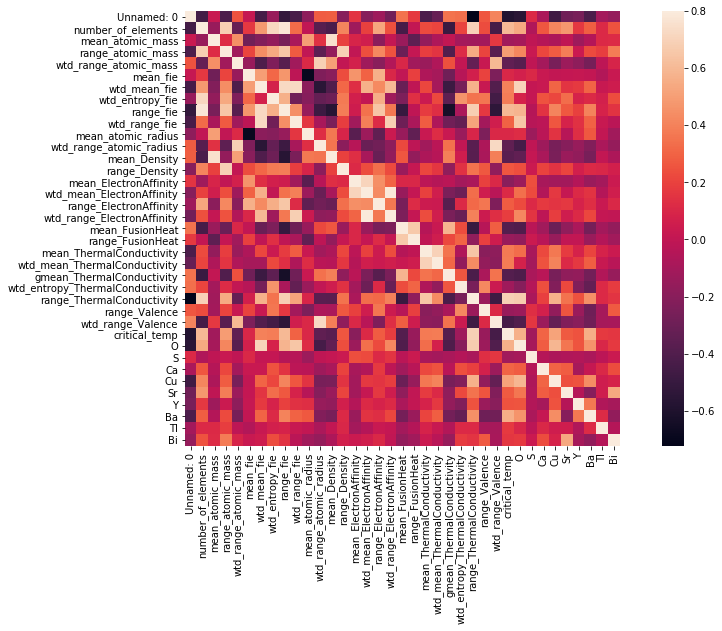

In [13]:
plt.figure(figsize=(15,8))
corrmat = df.corr()
sns.heatmap(corrmat, vmax=.8, square=True);

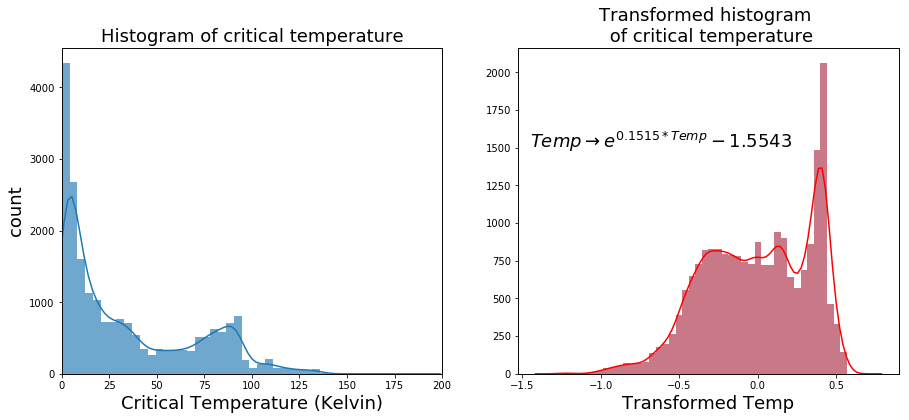

In [31]:
df = pd.read_csv('data_filtered.csv').drop('Unnamed: 0',axis=1)
y = df['critical_temp']
e=0.1515151515151516
y_mean = y.apply(lambda x: (x**e)).mean()
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title('Histogram of critical temperature',fontsize=18)
ax1 = sns.distplot(y, kde=False)
# Creating another Y axis
second_ax1 = ax1.twinx()
#Plotting kde without hist on the second Y axis
sns.distplot(y, ax=second_ax1, kde=True, hist=True)
#Removing Y ticks from the second axis
second_ax1.set_yticks([])
ax1.set_ylabel('count',fontsize=18)
ax1.set_xlabel('Critical Temperature (Kelvin)',fontsize=18)
plt.xlim(0,200)

plt.subplot(1,2,2)
plt.title('Transformed histogram \n of critical temperature',fontsize=18)
transform_text = r'$Temp\rightarrow e^{0.1515*Temp}-1.5543$'
transformed = y.apply(lambda x: (x**e)-y_mean)
ax2 = sns.distplot(transformed, kde=False)
# Creating another Y axis
second_ax2 = ax2.twinx()
#Plotting kde without hist on the second Y axis
sns.distplot(transformed, ax=second_ax2, kde=True, hist=True,color='red')
#Removing Y ticks from the second axis
second_ax2.set_yticks([])
ax2.text(-1.45,1500,transform_text,fontsize=18)
ax2.set_xlabel('Transformed Temp',fontsize=18)
plt.subplots_adjust(wspace=0.2)
plt.show()

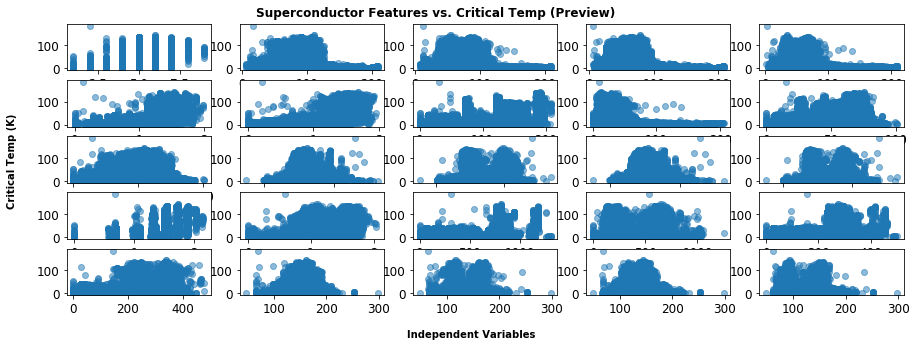

<Figure size 432x288 with 0 Axes>

In [85]:
#Preview of scatter plots between the dependent variable, 'critical temp', and the independent variables of 'feature_data'.
feature_data = pd.read_csv('train.csv')
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15,5))
fig.text(0.3, 0.9, 'Superconductor Features vs. Critical Temp (Preview)', fontsize='large', weight='bold')
fig.text(0.5, 0.01, 'Independent Variables', ha='center', fontsize='medium', weight='bold')
fig.text(0.07, 0.5, 'Critical Temp (K)', va='center', rotation='vertical', fontsize='medium', weight='bold')
for i, ax in enumerate(axes.flatten()):
    ax.scatter(feature_data.iloc[:,i], feature_data.iloc[:,81], alpha=0.5)
    ax.tick_params(axis='both',labelsize=12)

plt.show()
plt.tight_layout()

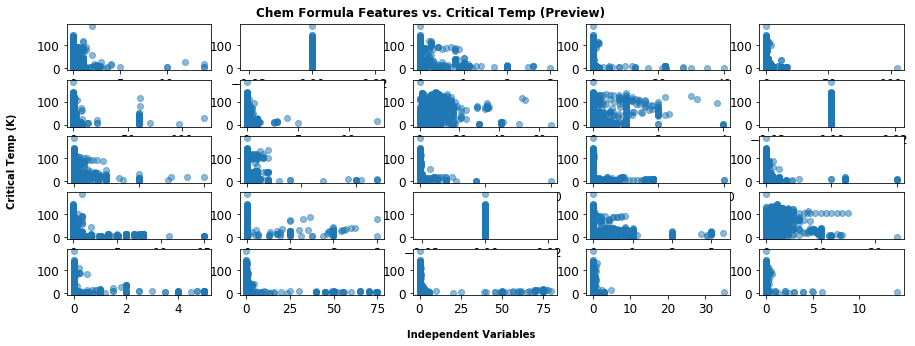

In [86]:
# Preview of scatter plots between the dependent variable, 'critical temp', and the independent variables of 'sc_chem_formula'.
sc_chem_formula = pd.read_csv('unique_m.csv')
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15,5))
fig.text(0.3, 0.9, 'Chem Formula Features vs. Critical Temp (Preview)', fontsize='large', weight='bold')
fig.text(0.5, 0.01, 'Independent Variables', ha='center', fontsize='medium', weight='bold')
fig.text(0.07, 0.5, 'Critical Temp (K)', va='center', rotation='vertical', fontsize='medium', weight='bold')
for i, ax in enumerate(axes.flatten()):
    ax.scatter(sc_chem_formula.iloc[:,i], sc_chem_formula.iloc[:,86], alpha=0.5)
    ax.tick_params(axis='both',labelsize=12)

plt.show()

In [67]:
e=0.1515151515151516
intercept = 1.5542
y_t = y.apply(lambda x: (x**e)-intercept)
X_train, X_test, y_train, y_test = train_test_split(X, y_t, test_size=0.3, random_state=42)

In [56]:
uni_reg = LinearRegression()
uni_reg.fit(X_train, y_train)
y_pred = uni_reg.predict(X_test)
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 : ',r2_score(y_test, y_pred))

Mean Absolute Error: 0.14069404576805655
Mean Squared Error: 0.03388799410648372
Root Mean Squared Error: 0.1840869199766342
R2 :  0.7028640541493161


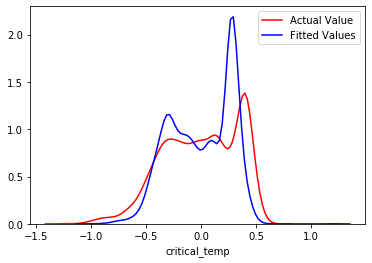

In [57]:
%matplotlib inline 
import seaborn as sns
ax1 = sns.distplot(y_test, hist=False, color="r", label="Actual Value")
sns.distplot(y_pred, hist=False, color="b", label="Fitted Values" , ax=ax1);

In [114]:
from sklearn import  preprocessing
from sklearn.model_selection import KFold
X_scaled = preprocessing.MinMaxScaler()
X = X_scaled.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y_t, test_size=0.3, random_state=42)

In [115]:
kf = KFold(n_splits=5)
kf.get_n_splits(X)
accuracy_res = []
prediction_df = []
count=1
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test, y_train, y_test = train_test_split(X, y_t, test_size=0.3, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train,y_train)
    predictions = model.predict(X_test)
    accuracy = model.score(X_test,y_test)
    accuracy_res.append(accuracy)    
    prediction_df.append(predictions.tolist())    
    print (count)
    count +=1

TRAIN: [ 4253  4254  4255 ... 21260 21261 21262] TEST: [   0    1    2 ... 4250 4251 4252]
1
TRAIN: [    0     1     2 ... 21260 21261 21262] TEST: [4253 4254 4255 ... 8503 8504 8505]
2
TRAIN: [    0     1     2 ... 21260 21261 21262] TEST: [ 8506  8507  8508 ... 12756 12757 12758]
3
TRAIN: [    0     1     2 ... 21260 21261 21262] TEST: [12759 12760 12761 ... 17008 17009 17010]
4
TRAIN: [    0     1     2 ... 17008 17009 17010] TEST: [17011 17012 17013 ... 21260 21261 21262]
5


In [ ]:
#Linear Regression

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
accuracy is:  70.28640541493175 %


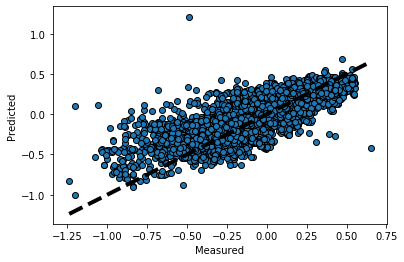

In [78]:
model = LinearRegression()
model.fit(X_train,y_train)
print (model)

predictions = model.predict(X_test)
accuracy = model.score(X_test,y_test)

print ("accuracy is: ",accuracy*100,'%')

fig, ax = plt.subplots()
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [ ]:
#Ridge Regression

In [97]:
X_train = df.drop(['number_of_elements','critical_temp'],axis=1)
Y = df['critical_temp']

X_scaled = preprocessing.MinMaxScaler()
X = X_scaled.fit_transform(X_train)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

accuracy is:  66.84444330162529 %


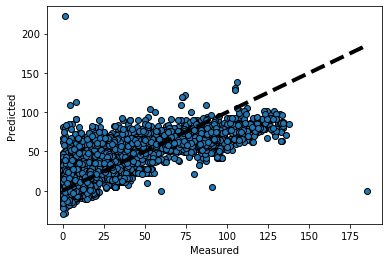

In [98]:
model = Ridge(alpha=0.05)
model.fit(X_train,y_train)

predictions = model.predict(X_test)
accuracy = model.score(X_test,y_test)

print ("accuracy is: ",accuracy*100,'%')


fig, ax = plt.subplots()
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [ ]:
#Lasso Regression

accuracy is:  63.11639634807717 %


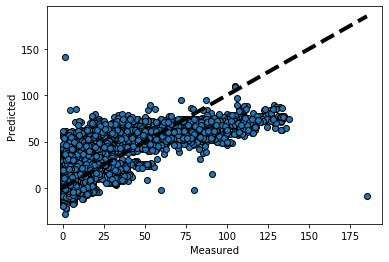

In [100]:
model = Lasso(alpha=0.1)
model.fit(X_train,y_train)

predictions = model.predict(X_test)
accuracy = model.score(X_test,y_test)

print ("accuracy is: ",accuracy*100,'%')


fig, ax = plt.subplots()
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [ ]:
#Decision Tree

Mean Absolute Error: 0.06996589901947384
Root Mean Squared Error: 0.12514458821804794
      Actual  Predicted
0  -0.229406  -0.122322
1   0.427185   0.400332
2   0.181046   0.102586
3   0.008050  -0.014870
4  -0.116108  -0.107361
5   0.314650   0.388237
6   0.402650   0.418521
7   0.255269   0.282043
8   0.159559   0.159559
9  -0.183330  -0.062588
10 -0.205154  -0.206974
11  0.177568   0.178266
12  0.148223   0.074380
13  0.144348  -0.037139
14 -0.278042  -0.379139
15  0.194585  -0.097023
16  0.040931  -0.122322
17  0.388237   0.328078
18  0.377021   0.380224
19  0.423546   0.423656

accuracy is:  69.81008653704338 %


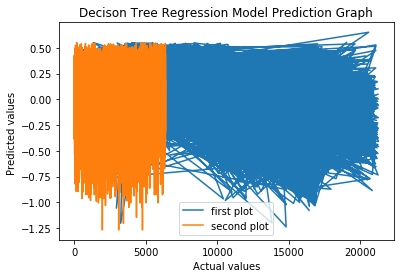

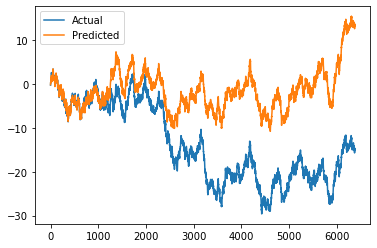

In [116]:
from sklearn.tree import DecisionTreeRegressor
import sklearn.metrics as metrics

regressor = DecisionTreeRegressor(random_state=0)

regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_test)

MAE_DT=metrics.mean_absolute_error(y_test, y_pred) 
SQRT_DT=np.sqrt(metrics.mean_squared_error(y_test, y_pred))


print('Mean Absolute Error:', MAE_DT)  
print('Root Mean Squared Error:',SQRT_DT )


# visulizing distance

b3 = y_test.ravel()
c3 = y_pred.ravel()  

df = pd.DataFrame({'Actual': b3, 'Predicted': c3})   
print(df.head(20))

# Plotting Graph

plt.plot(y_test, label='first plot')
plt.plot(y_pred, label='second plot')
plt.title("Decison Tree Regression Model Prediction Graph")
plt.xlabel("Actual values")
plt.ylabel("Predicted values ")
plt.legend()

# Graph 

df = df.cumsum();
df.plot();




accuracy = model.score(X_test,y_test)

print ("\naccuracy is: ",accuracy*100,'%')

In [ ]:
#K-Means CLustering

In [ ]:
#Hierarchical Agglomerative Clustering

In [129]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df = pd.read_csv('data_filtered.csv').drop('Unnamed: 0',axis=1)


In [130]:
import matplotlib.pyplot as plt

fig1 = plt.figure(figsize=(30,700))

k = 0
for INDEX, i in enumerate(df.columns):
    for index,j in enumerate(df.columns):
        k = k+1
        fig1.add_subplot(324,4,k)
        plt.title(str(i)+'/'+str(j))
        plt.scatter(df[i],df[j])

    
plt.subplots_adjust(hspace=0.4,wspace=0.5)
plt.show()

MemoryError: In RendererAgg: Out of memory

<Figure size 2160x50400 with 1296 Axes>

In [ ]:
#Apriori Algorithm

In [131]:
dataset = [['Milk', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Dill', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Milk', 'Apple', 'Kidney Beans', 'Eggs'],
           ['Milk', 'Unicorn', 'Corn', 'Kidney Beans', 'Yogurt'],
           ['Corn', 'Onion', 'Onion', 'Kidney Beans', 'Ice cream', 'Eggs']]

In [133]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

,Apple,Corn,Dill,Eggs,Ice cream,Kidney Beans,Milk,Nutmeg,Onion,Unicorn,Yogurt
0,False,False,False,True,False,True,True,True,True,False,True
1,False,False,True,True,False,True,False,True,True,False,True
2,True,False,False,True,False,True,True,False,False,False,False
3,False,True,False,False,False,True,True,False,False,True,True
4,False,True,False,True,True,True,False,False,True,False,False


In [134]:
from mlxtend.frequent_patterns import apriori

apriori(df, min_support=0.6)

,support,itemsets
0,0.8,(3)
1,1.0,(5)
2,0.6,(6)
3,0.6,(8)
4,0.6,(10)
5,0.8,"(3, 5)"
6,0.6,"(8, 3)"
7,0.6,"(5, 6)"
8,0.6,"(8, 5)"
9,0.6,"(10, 5)"


In [135]:
apriori(df, min_support=0.6, use_colnames=True)

,support,itemsets
0,0.8,(Eggs)
1,1.0,(Kidney Beans)
2,0.6,(Milk)
3,0.6,(Onion)
4,0.6,(Yogurt)
5,0.8,"(Eggs, Kidney Beans)"
6,0.6,"(Eggs, Onion)"
7,0.6,"(Milk, Kidney Beans)"
8,0.6,"(Kidney Beans, Onion)"
9,0.6,"(Kidney Beans, Yogurt)"


In [ ]:
# FP Growth

In [136]:
from mlxtend.frequent_patterns import fpgrowth

fpgrowth(df, min_support=0.6)

,support,itemsets
0,1.0,(5)
1,0.8,(3)
2,0.6,(10)
3,0.6,(8)
4,0.6,(6)
5,0.8,"(3, 5)"
6,0.6,"(10, 5)"
7,0.6,"(8, 3)"
8,0.6,"(8, 5)"
9,0.6,"(8, 3, 5)"


In [137]:
fpgrowth(df, min_support=0.6, use_colnames=True)

,support,itemsets
0,1.0,(Kidney Beans)
1,0.8,(Eggs)
2,0.6,(Yogurt)
3,0.6,(Onion)
4,0.6,(Milk)
5,0.8,"(Eggs, Kidney Beans)"
6,0.6,"(Kidney Beans, Yogurt)"
7,0.6,"(Eggs, Onion)"
8,0.6,"(Kidney Beans, Onion)"
9,0.6,"(Eggs, Kidney Beans, Onion)"
